## Webscraping TorontoRentals.com 

### At the time I was moving and was interested at the going rental rates of condos in the various boroughs of Toronto

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd # For converting results to a dataframe and bar chart plots
import json # For parsing json
%matplotlib inline
from random import randint
import matplotlib.pyplot as plt
import numpy as np

## Making a request

In [3]:
page_url = 'https://www.torontorentals.com/toronto/condos?beds=2B'

In [4]:
response_toronto = requests.get(page_url)

## Request Status

In [5]:
response_toronto.status_code

200

In [6]:
response_toronto.headers

{'Date': 'Fri, 03 Jul 2020 19:44:13 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Set-Cookie': '__cfduid=d179f937a12c7006b7809e8d5c98cca7b1593805445; expires=Sun, 02-Aug-20 19:44:05 GMT; path=/; domain=.torontorentals.com; HttpOnly; SameSite=Lax', 'Vary': 'Accept-Encoding, Cookie', 'Cache-Control': 'max-age=14400', 'CF-Cache-Status': 'MISS', 'cf-request-id': '03b7ce2ff00000f0bd07064200000001', 'Expect-CT': 'max-age=604800, report-uri="https://report-uri.cloudflare.com/cdn-cgi/beacon/expect-ct"', 'Server': 'cloudflare', 'CF-RAY': '5ad3195fec5cf0bd-IAD', 'Content-Encoding': 'gzip'}

In [7]:
response_toronto.content

b'<!DOCTYPE html>\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!--> <html class="no-js" lang="en"> <!--<![endif]-->\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n<title>Toronto, ON Condos For Rent</title>\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<meta name="apple-mobile-web-app-capable" content="yes" />\n<link rel="preconnect" href="https://maps.googleapis.com">\n<link rel="preconnect" href="https://maps.gstatic.com">\n<link rel="preconnect" href="https://fonts.googleapis.com">\n<link rel="preconnect" href="https://cdn2.torontorentals.com">\n<link rel="preconnect" href="https://www.google-analytics.com">\n<link rel="preconnect" href="https://fonts.gstatic.com">\n<link rel="preconnect" href="https://stats.g.doubleclick

## BeautifulSoup object to parse content

In [8]:
soup = BeautifulSoup(response_toronto.content)

In [9]:
soup

<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]--><!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]--><!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]--><!--[if gt IE 8]><!--><html class="no-js" lang="en"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<title>Toronto, ON Condos For Rent</title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<meta content="yes" name="apple-mobile-web-app-capable"/>
<link href="https://maps.googleapis.com" rel="preconnect"/>
<link href="https://maps.gstatic.com" rel="preconnect"/>
<link href="https://fonts.googleapis.com" rel="preconnect"/>
<link href="https://cdn2.torontorentals.com" rel="preconnect"/>
<link href="https://www.google-analytics.com" rel="preconnect"/>
<link href="https://fonts.gstatic.com" rel="preconnect"/>
<link href="https://stats.g.doubleclick.net" rel="preconnect"/>
<link h

## Taking city, types, beds as parameters

In [10]:
def url_get(city, types, beds):
    url = f'https://www.torontorentals.com/{city}/{types}?beds={beds}%2B'
    response_toronto = requests.get(url)
    soup = BeautifulSoup(response_toronto.content)
    return soup

soup=url_get('toronto', 'condos', '2')


In [11]:
#postal codes
postal_codes = []
for PostalCode in soup.find_all('span', class_='replace zip'):
    if PostalCode.get_text(strip=True) == '':
        pass
    else:
        postal_codes.append(PostalCode.get_text(strip=True))
postal_codes

['- M5A 3N8',
 '- M1H 3G6',
 '- M1H 3J2',
 '- M1H 3H3',
 '- M1S 0L7',
 '- M1P 0B1',
 '- M1P 0B1',
 '- M1H 3H3',
 '- M1P 0B1',
 '- M1H 3K2',
 '-']

In [12]:
#price
[Price.get_text(strip=True) for Price in soup.find_all('span', class_='replace rent')]

['$3,985',
 '$2,450',
 '$2,500',
 '$2,300',
 '$2,900',
 '$2,350',
 '$2,100',
 '$2,350',
 '$2,150',
 '$2,100',
 '']

In [13]:
#bedroom 
for beds in soup.find_all('div',class_='bottom-line d-xl-none'):
    print(beds.find('span',class_='beds finer-detail').get_text(strip=True))

4Bd
2Bd
2Bd
2Bd
4Bd
2Bd
2Bd
2Bd
2Bd
2Bd
Bd


In [14]:
def get_page(city, types, beds, page):
    
    url = f'https://www.torontorentals.com/{city}/{types}?beds={beds}&p={page}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'lxml')
    return soup

In [15]:
data = {
    'monthly_rent': [],
    'postal_code': [],
    'square_feet': []
}

for page in range(1, 200//11 + 1):
    soup = get_page('toronto', 'condos', '2', page)
    
    sleep(randint(1,5))
    
    for tag in soup.find_all('span', class_ = 'replace rent'):
        rent = tag.get_text(strip=True)
        if rent == '':
            pass
        else:
            data['monthly_rent'].append(rent)
        
    for tag in soup.find_all('span', class_ = 'replace zip'):
        pcode = tag.get_text(strip=True)[2:]
        if pcode == '':
            pass
        else:
            data['postal_code'].append(pcode)
            
    for each in soup.find_all(class_='paginated-listing'):
        try:
            data['square_feet'].append(each.find('div',class_='bottom-line d-xl-none').find('span', class_='replace dimensions').get_text(strip=True))
        except:
            data['square_feet'].append('missing')
       

#     for sqft in soup.find_all('div',class_='bottom-line d-xl-none'):
#         try:
#             if sqft.find('span',class_='dims finer-detail').get_text(strip=True) != '':
#                 data['square_feet'].append(sqft.find('span',class_='dims finer-detail').get_text(strip=True))
#         except:
#             data['square_feet'].append('missing')

In [16]:
data['square_feet']

['',
 '1100ft2',
 '950ft2',
 '850ft2',
 '1500ft2',
 '900ft2',
 '800ft2',
 '900ft2',
 '700ft2',
 '750ft2',
 '1100ft2',
 '900ft2',
 '850ft2',
 '785ft2',
 '1100ft2',
 '800ft2',
 '950ft2',
 '900ft2',
 '1400ft2',
 '850ft2',
 '850ft2',
 '1200ft2',
 '1500ft2',
 '890ft2',
 '700ft2',
 '900ft2',
 '1100ft2',
 '728ft2',
 '650ft2',
 '750ft2',
 '700ft2',
 '1100ft2',
 '850ft2',
 '750ft2',
 '850ft2',
 '700ft2',
 '900ft2',
 '800ft2',
 '870ft2',
 '850ft2',
 '850ft2',
 '932ft2',
 '1000ft2',
 '800ft2',
 '800ft2',
 '1000ft2',
 '1100ft2',
 '950ft2',
 '1100ft2',
 '954ft2',
 '1000ft2',
 '1085ft2',
 '2050ft2',
 '932ft2',
 '1100ft2',
 '850ft2',
 '1250ft2',
 '850ft2',
 '850ft2',
 '1000ft2',
 '900ft2',
 '850ft2',
 '650ft2',
 '1300ft2',
 '932ft2',
 '1100ft2',
 '850ft2',
 '950ft2',
 '850ft2',
 '850ft2',
 '750ft2',
 '850ft2',
 '900ft2',
 '850ft2',
 '850ft2',
 '950ft2',
 '850ft2',
 '1367ft2',
 '932ft2',
 '1100ft2',
 '750ft2',
 '750ft2',
 '840ft2',
 '800ft2',
 '800899ft2',
 '800ft2',
 '650ft2',
 '900ft2',
 '878ft2',
 

In [17]:
data['postal_code']

['M5A 3N8',
 'M1H 3G6',
 'M1H 3J2',
 'M1H 3H3',
 'M1S 0L7',
 'M1P 0B1',
 'M1P 0B1',
 'M1H 3H3',
 'M1P 0B1',
 'M1H 3K2',
 'M1H 3G5',
 'M1P 0A9',
 'M1H 3H3',
 'M1H 0A2',
 'M1H 3H3',
 'M1H 3J7',
 'M1P 0B2',
 'M1K 5J3',
 'M1W 3V4',
 'M1H 3H5',
 'M1H 3J5',
 'M1P 0B5',
 'M1V 5E9',
 'M1H 3J2',
 'M1N 1C8',
 'M1P 5J5',
 'M1W 3W2',
 'M1S 0L1',
 'M1H 3K2',
 'M1H 3J5',
 'M1P 0B1',
 'M1H 3H3',
 'M1P 5E5',
 'M1H 3K2',
 'M1P 0B2',
 'M1P 0B1',
 'M1H 3J2',
 'M1S 0L1',
 'M1P 0B2',
 'M1H 3K2',
 'M1H 3K2',
 'M1E 5E6',
 'M1J 3K4',
 'M1H 3J7',
 'M1P 0B2',
 'None',
 'M1S 1T1',
 'M1P 0B2',
 'M1W 3W1',
 'M1V 5M3',
 'M1P 4Z4',
 'M1N 1C8',
 'M1S 3H1',
 'M1E 5E6',
 'M1S 4L1',
 'M1S 0K5',
 'M1V 4X9',
 'M1H 3J5',
 'M1H 3K2',
 'M1H 3G5',
 'M1K 5J3',
 'M1P 0A9',
 'M1P 0B1',
 'M1E 4V4',
 'M1E 5E6',
 'M1H 3G5',
 'M1H 3K2',
 'M1H 3J2',
 'M1H 3J7',
 'M1H 3K2',
 'M1H 3K2',
 'M1H 3J7',
 'M1K 5J3',
 'M1H 3J5',
 'M1H 3K2',
 'M1H 3H3',
 'M1H 3J7',
 'M1K 5J3',
 'M1E 5E6',
 'L4J 7K9',
 'L4K 0K6',
 'L4K 2M7',
 'L4L 0G7',
 'L4K 1

In [18]:
data['monthly_rent']

['$3,985',
 '$2,450',
 '$2,500',
 '$2,300',
 '$2,900',
 '$2,350',
 '$2,100',
 '$2,350',
 '$2,150',
 '$2,100',
 '$2,450',
 '$2,600',
 '$2,300',
 '$2,000',
 '$2,700',
 '$2,250',
 '$2,880',
 '$2,300',
 '$2,500',
 '$2,300',
 '$2,490',
 '$2,800',
 '$2,450',
 '$2,200',
 '$2,150',
 '$2,800',
 '$2,200',
 '$2,200',
 '$2,100',
 '$2,100',
 '$2,200',
 '$2,700',
 '$2,600',
 '$2,000',
 '$2,700',
 '$2,100',
 '$2,150',
 '$2,650',
 '$2,900',
 '$2,400',
 '$2,500',
 '$2,250',
 '$2,300',
 '$2,250',
 '$2,500',
 '$2,750',
 '$2,300',
 '$2,900',
 '$2,220',
 '$2,200',
 '$2,300',
 '$3,150',
 '$2,250',
 '$2,250',
 '$2,000',
 '$2,250',
 '$2,100',
 '$2,500',
 '$2,350',
 '$2,400',
 '$2,300',
 '$2,450',
 '$2,400',
 '$2,450',
 '$2,250',
 '$2,500',
 '$2,500',
 '$2,400',
 '$2,450',
 '$2,350',
 '$2,000',
 '$2,450',
 '$2,300',
 '$2,500',
 '$2,350',
 '$2,500',
 '$2,150',
 '$2,400',
 '$2,250',
 '$2,450',
 '$2,100',
 '$2,200',
 '$2,500',
 '$2,150',
 '$2,350',
 '$2,650',
 '$2,200',
 '$2,500',
 '$2,600',
 '$3,750',
 '$2,200',

In [19]:
len(data['postal_code'])

180

In [20]:
len(data['monthly_rent'])

180

In [21]:
len(data['square_feet'])  

180

In [22]:
torental=pd.DataFrame(data)

In [23]:
torental

,monthly_rent,postal_code,square_feet
0,"$3,985",M5A 3N8,
1,"$2,450",M1H 3G6,1100ft2
2,"$2,500",M1H 3J2,950ft2
3,"$2,300",M1H 3H3,850ft2
4,"$2,900",M1S 0L7,1500ft2
...,...,...,...
175,"$3,400",M5V 4B3,1055ft2
176,"$2,650",M5H 0B1,
177,"$2,800",M5V 4A5,
178,"$2,700",M4S 0B9,795ft2


In [24]:
type(data['postal_code'])

list

In [25]:
type(data['monthly_rent'])

list

## Getting FSA from Postal Code

In [26]:
l=[]
for i in range(len(data['postal_code'])):
    l.append(data['postal_code'][i][:3])
l

['M5A',
 'M1H',
 'M1H',
 'M1H',
 'M1S',
 'M1P',
 'M1P',
 'M1H',
 'M1P',
 'M1H',
 'M1H',
 'M1P',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1P',
 'M1K',
 'M1W',
 'M1H',
 'M1H',
 'M1P',
 'M1V',
 'M1H',
 'M1N',
 'M1P',
 'M1W',
 'M1S',
 'M1H',
 'M1H',
 'M1P',
 'M1H',
 'M1P',
 'M1H',
 'M1P',
 'M1P',
 'M1H',
 'M1S',
 'M1P',
 'M1H',
 'M1H',
 'M1E',
 'M1J',
 'M1H',
 'M1P',
 'Non',
 'M1S',
 'M1P',
 'M1W',
 'M1V',
 'M1P',
 'M1N',
 'M1S',
 'M1E',
 'M1S',
 'M1S',
 'M1V',
 'M1H',
 'M1H',
 'M1H',
 'M1K',
 'M1P',
 'M1P',
 'M1E',
 'M1E',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1K',
 'M1H',
 'M1H',
 'M1H',
 'M1H',
 'M1K',
 'M1E',
 'L4J',
 'L4K',
 'L4K',
 'L4L',
 'L4K',
 'L4K',
 'L4L',
 'L4K',
 'L4L',
 'L4K',
 'M4M',
 'M4M',
 'M5J',
 'M5V',
 'M5V',
 'M5B',
 'M4P',
 'M5V',
 'M5A',
 'M5A',
 'M5A',
 'M5P',
 'M4L',
 'M5V',
 'M5E',
 'M5J',
 'M4S',
 'M5V',
 'M5J',
 'M5E',
 'M5B',
 'M5S',
 'M5S',
 'M6J',
 'M5V',
 'M5A',
 'M5A',
 'M5B',
 'M4Y',
 'M4M',
 'M5J',
 'M5V',
 'M4P',
 'Non',
 'M4V',
 'M4X',


In [27]:
pc3=pd.DataFrame(l)

In [28]:
pc3

,0
0,M5A
1,M1H
2,M1H
3,M1H
4,M1S
...,...
175,M5V
176,M5H
177,M5V
178,M4S


## Concatenate the FSA with Rent, Postal Code, Square feet

In [29]:
pcconcat=pd.concat([torental,pc3],axis=1)

In [30]:
pcconcat.columns=['monthly_rent','postal_code','square_feet', 'outerCode']

In [31]:
pcconcat

,monthly_rent,postal_code,square_feet,outerCode
0,"$3,985",M5A 3N8,,M5A
1,"$2,450",M1H 3G6,1100ft2,M1H
2,"$2,500",M1H 3J2,950ft2,M1H
3,"$2,300",M1H 3H3,850ft2,M1H
4,"$2,900",M1S 0L7,1500ft2,M1S
...,...,...,...,...
175,"$3,400",M5V 4B3,1055ft2,M5V
176,"$2,650",M5H 0B1,,M5H
177,"$2,800",M5V 4A5,,M5V
178,"$2,700",M4S 0B9,795ft2,M4S


## Parse FSA along with Borough, Neighbourhood

In [32]:
url1 = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
hood_data = requests.get(url1).text
neighbour_data = BeautifulSoup(hood_data, 'lxml')

In [33]:
column_names = ['PostalcodeN','Borough','Neighbourhood']
toronto = pd.DataFrame(columns = column_names)

content = neighbour_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcodeN = 0
borough = 0
neighbourhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcodeN = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n')
            i = i + 1
        elif i == 2: 
            neighbourhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'PostalcodeN': postcodeN,'Borough': borough,'Neighbourhood': neighbourhood},ignore_index=True)

In [34]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [35]:
pcarea = toronto.groupby(['PostalcodeN','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
pcarea.head()

,PostalcodeN,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [36]:
pcarea = pcarea.dropna()
empty = 'Not assigned'
pcarea = pcarea[(pcarea.PostalcodeN != empty ) & (pcarea.Borough != empty) & (pcarea.Neighbourhood != empty)]

In [37]:
pcarea.head(100)

,PostalcodeN,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
95,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe..."
96,M9L,North York,Humber Summit
97,M9M,North York,"Humberlea, Emery"
98,M9N,York,Weston


## Concatenate the Locations with Condo data

In [38]:
all=pcconcat.merge(pcarea,how='inner',left_on='outerCode',right_on='PostalcodeN')

In [39]:
all

,monthly_rent,postal_code,square_feet,outerCode,PostalcodeN,Borough,Neighbourhood
0,"$3,985",M5A 3N8,,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,"$2,500",M5A 1Z4,669ft2,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,"$3,600",M5A 0N8,935ft2,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,"$3,000",M5A 4E8,,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,"$3,200",M5A 1M1,,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...,...,...,...
163,"$3,200",M5G 2K2,820ft2,M5G,M5G,Downtown Toronto,Central Bay Street
164,"$2,800",M6S 3N4,1100ft2,M6S,M6S,West Toronto,"Runnymede, Swansea"
165,"$2,395",M6H 4K6,,M6H,M6H,West Toronto,"Dufferin, Dovercourt Village"
166,"$2,650",M5H 0B1,,M5H,M5H,Downtown Toronto,"Richmond, Adelaide, King"


In [40]:
len(all)

168

## Cleaning data

In [41]:

pcconcat['monthly_rent'] = pcconcat['monthly_rent'].str.replace(',','')


In [42]:
pcconcat['monthly_rent'] = pcconcat['monthly_rent'].str.replace('$','')

In [43]:
pcconcat['square_feet'] = pcconcat['square_feet'].str.replace('ft2','')

In [48]:
pcconcat['square_feet'] = pcconcat['square_feet'].replace('',np.nan)

In [49]:
pcconcat['monthly_rent'] = pcconcat['monthly_rent'].replace('',np.nan)

In [52]:
pcconcat

,monthly_rent,postal_code,square_feet,outerCode
0,3985,M5A 3N8,NaN,M5A
1,2450,M1H 3G6,1100,M1H
2,2500,M1H 3J2,950,M1H
3,2300,M1H 3H3,850,M1H
4,2900,M1S 0L7,1500,M1S
...,...,...,...,...
175,3400,M5V 4B3,1055,M5V
176,2650,M5H 0B1,NaN,M5H
177,2800,M5V 4A5,NaN,M5V
178,2700,M4S 0B9,795,M4S


In [1]:
# Testing to match with website

In [53]:
pcconcat.iloc[151]['square_feet']

'932'

In [54]:
type(pcconcat['monthly_rent'].values)

numpy.ndarray

In [55]:
Rental_Neighbourhood=pcconcat.merge(pcarea,how='inner',left_on='outerCode',right_on='PostalcodeN')

In [57]:
rental = Rental_Neighbourhood.copy()

In [2]:
# Cleaning of Final Dataframe

In [58]:
dashes = []
for i in range(len(rental['monthly_rent'])):
    if '-' in rental.iloc[i]['monthly_rent']:
        dashes.append(i)

In [59]:
dashes

[119, 146]

In [60]:
rental = rental.drop(dashes)

In [61]:
rental['monthly_rent'] = rental['monthly_rent'].astype(int)

In [62]:
rental['square_feet'] = rental['square_feet'].astype(float)

In [63]:
rental = rental.drop(columns='PostalcodeN')

In [64]:
rental

,monthly_rent,postal_code,square_feet,outerCode,Borough,Neighbourhood
0,3985,M5A 3N8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,2500,M5A 1Z4,669.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,3600,M5A 0N8,935.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,3000,M5A 4E8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,3200,M5A 1M1,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...,...,...
163,3200,M5G 2K2,820.0,M5G,Downtown Toronto,Central Bay Street
164,2800,M6S 3N4,1100.0,M6S,West Toronto,"Runnymede, Swansea"
165,2395,M6H 4K6,NaN,M6H,West Toronto,"Dufferin, Dovercourt Village"
166,2650,M5H 0B1,NaN,M5H,Downtown Toronto,"Richmond, Adelaide, King"


In [68]:
type(rental['square_feet'].iloc[0])

numpy.float64

## Some values from the features

In [71]:
chart_outerCode=rental['Borough'].value_counts(ascending=False)

In [72]:
chart_outerCode

Scarborough         77
Downtown Toronto    65
Central Toronto     12
West Toronto         7
East Toronto         5
Name: Borough, dtype: int64

In [73]:
rental['monthly_rent'].sort_values(ascending=False)

113    7000
102    6000
117    5000
167    4900
136    4000
       ... 
49     2000
38     2000
108    2000
16     2000
25     2000
Name: monthly_rent, Length: 166, dtype: int32

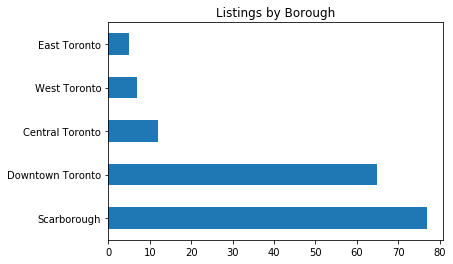

In [74]:
chart_outerCode.plot(kind='barh').set(title='Listings by Borough');

In [75]:
rental.groupby(['monthly_rent','Neighbourhood'])['square_feet'].count()

monthly_rent  Neighbourhood                                                                                             
2000          Agincourt                                                                                                     1
              CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport    1
              Cedarbrae                                                                                                     3
2050          Regent Park, Harbourfront                                                                                     0
2100          Cedarbrae                                                                                                     3
                                                                                                                           ..
4000          India Bazaar, The Beaches West                                                                               

In [76]:
rental.groupby('postal_code').aggregate(['min','mean','max'])

monthly_rent               square_feet                     
                     min    mean   max         min         mean     max
postal_code                                                            
M1E 4V4             2450  2450.0  2450      1300.0  1300.000000  1300.0
M1E 5E6             2250  2250.0  2250       932.0   932.000000   932.0
M1H 0A2             2000  2000.0  2000       785.0   785.000000   785.0
M1H 3G5             2400  2450.0  2500      1000.0  1066.666667  1100.0
M1H 3G6             2450  2450.0  2450      1100.0  1100.000000  1100.0
...                  ...     ...   ...         ...          ...     ...
M6J 0B1             2750  2750.0  2750         NaN          NaN     NaN
M6J 3K6             2450  2450.0  2450         NaN          NaN     NaN
M6K 3P8             3200  3200.0  3200         NaN          NaN     NaN
M6K 3S2             3200  3200.0  3200       850.0   850.000000   850.0
M6S 3N4             2800  2800.0  2800      1100.0  1100.000000  1100.0

[109 rows x 6 columns]

In [77]:
rental

,monthly_rent,postal_code,square_feet,outerCode,Borough,Neighbourhood
0,3985,M5A 3N8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,2500,M5A 1Z4,669.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,3600,M5A 0N8,935.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,3000,M5A 4E8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,3200,M5A 1M1,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...,...,...
163,3200,M5G 2K2,820.0,M5G,Downtown Toronto,Central Bay Street
164,2800,M6S 3N4,1100.0,M6S,West Toronto,"Runnymede, Swansea"
165,2395,M6H 4K6,NaN,M6H,West Toronto,"Dufferin, Dovercourt Village"
166,2650,M5H 0B1,NaN,M5H,Downtown Toronto,"Richmond, Adelaide, King"


In [78]:
chart_outerCode=rental['Borough'].value_counts().sort_values(ascending=True)
chart_outerCode


East Toronto         5
West Toronto         7
Central Toronto     12
Downtown Toronto    65
Scarborough         77
Name: Borough, dtype: int64

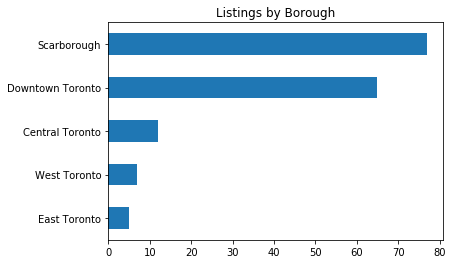

In [79]:
chart_outerCode.plot(kind='barh').set(title='Listings by Borough');

In [80]:
chart_Neighbourhood=rental['Neighbourhood'].value_counts().sort_values(ascending=True)
chart_Neighbourhood

Scarborough Village                                                                                            1
St. James Town, Cabbagetown                                                                                    1
Richmond, Adelaide, King                                                                                       1
Forest Hill North & West, Forest Hill Road Park                                                                1
Dufferin, Dovercourt Village                                                                                   1
The Annex, North Midtown, Yorkville                                                                            1
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park                                              1
India Bazaar, The Beaches West                                                                                 1
Runnymede, Swansea                                                                              

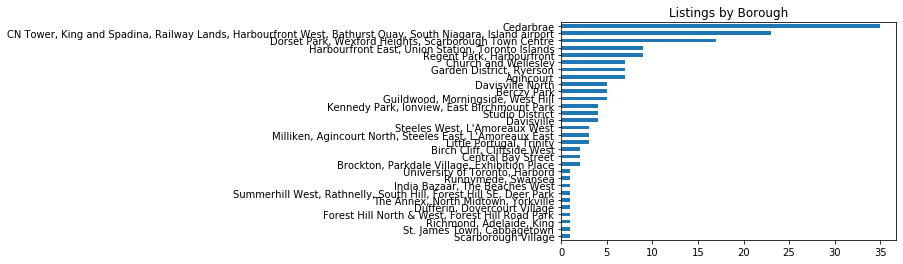

In [81]:
chart_Neighbourhood.plot(kind='barh').set(title='Listings by Borough');

In [82]:
rental.groupby('Borough')['monthly_rent'].agg(['min','mean','max'])

,min,mean,max
Borough,,,
Central Toronto,2550,3081.666667,4900
Downtown Toronto,2000,3070.784615,7000
East Toronto,2200,2870.000000,4000
Scarborough,2000,2380.389610,3150
West Toronto,2395,2742.142857,3200


In [83]:
rental.groupby('Borough')['monthly_rent'].agg(['min','mean','max']).sort_values(['mean'])

,min,mean,max
Borough,,,
Scarborough,2000,2380.389610,3150
West Toronto,2395,2742.142857,3200
East Toronto,2200,2870.000000,4000
Downtown Toronto,2000,3070.784615,7000
Central Toronto,2550,3081.666667,4900


In [84]:
chart_top_mean_hood = rental.groupby('Neighbourhood')['monthly_rent'].agg(['min','mean','max']).sort_values(['mean']).head()

In [85]:
chart_top_mean_hood

,min,mean,max
Neighbourhood,,,
"Milliken, Agincourt North, Steeles East, L'Amoreaux East",2100,2250.000000,2450
"Guildwood, Morningside, West Hill",2250,2290.000000,2450
Scarborough Village,2300,2300.000000,2300
"Steeles West, L'Amoreaux West",2200,2306.666667,2500
"Kennedy Park, Ionview, East Birchmount Park",2300,2325.000000,2400


In [86]:
chart_top_mean_hood = rental.groupby('Neighbourhood')['monthly_rent'].agg(['min','mean','max']).sort_values(['mean']).tail()

In [87]:
chart_top_mean_hood

,min,mean,max
Neighbourhood,,,
"Brockton, Parkdale Village, Exhibition Place",3200,3200.00000,3200
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",2000,3393.26087,7000
"University of Toronto, Harbord",3800,3800.00000,3800
"India Bazaar, The Beaches West",4000,4000.00000,4000
"The Annex, North Midtown, Yorkville",4900,4900.00000,4900


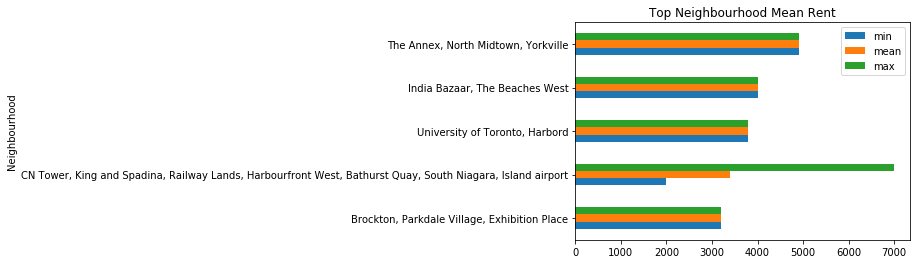

In [88]:
chart_top_mean_hood.plot(kind='barh').set(title='Top Neighbourhood Mean Rent');

In [89]:
chart_bottom_mean_hood = rental.groupby('Neighbourhood')['monthly_rent'].agg(['min','mean','max']).sort_values(['mean']).head()

In [90]:
chart_bottom_mean_hood

,min,mean,max
Neighbourhood,,,
"Milliken, Agincourt North, Steeles East, L'Amoreaux East",2100,2250.000000,2450
"Guildwood, Morningside, West Hill",2250,2290.000000,2450
Scarborough Village,2300,2300.000000,2300
"Steeles West, L'Amoreaux West",2200,2306.666667,2500
"Kennedy Park, Ionview, East Birchmount Park",2300,2325.000000,2400


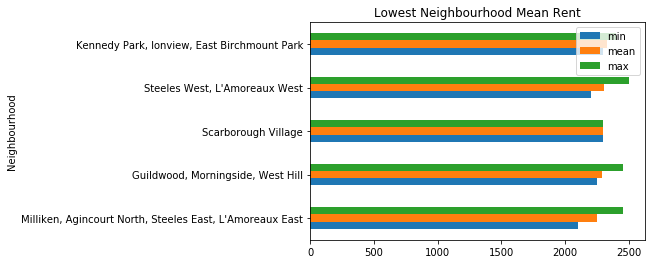

In [91]:
chart_bottom_mean_hood.plot(kind='barh').set(title='Lowest Neighbourhood Mean Rent');

## Scatterplot Rent vs Sq ft

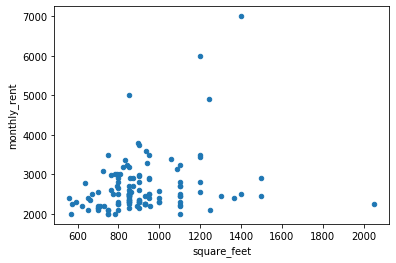

In [92]:
rental.plot(kind='scatter',x='square_feet',y='monthly_rent')

plt.show()

In [93]:
names=rental['Borough'].unique()

In [94]:
names

array(['Downtown Toronto', 'Scarborough', 'East Toronto',
       'Central Toronto', 'West Toronto'], dtype=object)

In [95]:
def right(df, a, column_name):
    return df[df['Borough'] == a][column_name]

In [96]:
markers=['o','v','1','2','3','s','x']

In [97]:
zipped =zip(names,markers)
tuple(zipped)

(('Downtown Toronto', 'o'),
 ('Scarborough', 'v'),
 ('East Toronto', '1'),
 ('Central Toronto', '2'),
 ('West Toronto', '3'))

In [98]:
rental

,monthly_rent,postal_code,square_feet,outerCode,Borough,Neighbourhood
0,3985,M5A 3N8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,2500,M5A 1Z4,669.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,3600,M5A 0N8,935.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,3000,M5A 4E8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,3200,M5A 1M1,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...,...,...
163,3200,M5G 2K2,820.0,M5G,Downtown Toronto,Central Bay Street
164,2800,M6S 3N4,1100.0,M6S,West Toronto,"Runnymede, Swansea"
165,2395,M6H 4K6,NaN,M6H,West Toronto,"Dufferin, Dovercourt Village"
166,2650,M5H 0B1,NaN,M5H,Downtown Toronto,"Richmond, Adelaide, King"


In [101]:
rentals = rental.copy().loc[(rental['Borough'] == 'Downtown Toronto') | (rental['Borough'] == 'Scarborough')]

In [103]:
rentals

,monthly_rent,postal_code,square_feet,outerCode,Borough,Neighbourhood
0,3985,M5A 3N8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,2500,M5A 1Z4,669.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,3600,M5A 0N8,935.0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,3000,M5A 4E8,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,3200,M5A 1M1,NaN,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...,...,...
157,2600,M4Y 1T1,NaN,M4Y,Downtown Toronto,Church and Wellesley
159,2975,M4X 1L1,900.0,M4X,Downtown Toronto,"St. James Town, Cabbagetown"
162,3000,M5G 2J9,NaN,M5G,Downtown Toronto,Central Bay Street
163,3200,M5G 2K2,820.0,M5G,Downtown Toronto,Central Bay Street


In [105]:
names = ['Downtown Toronto', 'Scarborough']

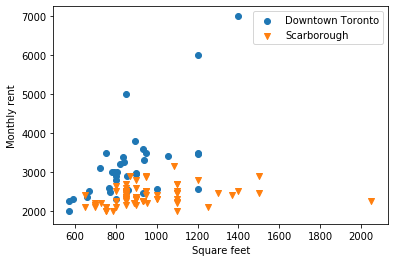

In [110]:
markers=['o','v','1','2','3','s','x']

for name,mark in zip(names,markers):
    square_feet= right(rental,name,'square_feet')
    monthly_rent= right(rental,name,'monthly_rent')
    
    plt.scatter(square_feet,monthly_rent,marker=mark,label=name)
    plt.xlabel('Square feet')
    plt.ylabel('Monthly rent')
plt.legend()